# Prática: Potenciais extracelulares em modelos neuronais

#### Biofísica de Membranas 2024.1 - Lavínia Mitiko Takarabe

Em caso de dúvidas escrever para: lavinia.mitiko@ufabc.edu.br

## Parte I - Modelos de neurônios simplificados

Neurônios simplificados do tipo pontuais capturam várias propriedades da atividade de disparo de potenciais de ação observada _in vivo_, mas eles não podem ser usados para a geração de sinais extracelulares. 

Nas aulas anteriores, nós vimos que neurônios pontuais (ou com um único compartimento) não podem gerar sinais extracelulares. Portanto, os modelos mais simples que podem gerar sinais extracelular são modelos de dois compartimentos em que um dos compartimentos representa o soma e o outro os dendritos. 

Nesta primeira parte da prática, nós vamos explorar a geração de potenciais extracelulares em modelos neuronais simplificados (dois compartimentos).

Lembrando que, para uma única fonte de corrente constante estática $i$ em um condutor que tem volume isotrópico (i.e., em que as propriedades físicas são as mesmas) com condutividade $\sigma$, o potencial ao redor da fonte de corrente é determinado por:

$$
\begin{equation}
V_\mathrm{e}(r)  = \frac{i}{4 \pi \sigma r}.
\label{eq:Ve_single_source}
\end{equation}
$$

Para os próximos exercícios, nós vamos considerar $\sigma=0.3$ S/m.

**Tarefa 0: Com base no que você viu na aula teórica, você consegue explicar por quê neurônios pontuais não podem gerar sinais extracelulares?**

#### Importando bibliotecas

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

#### Definindo a função que calcula o potencial extracelular

In [2]:
def calc_potencial_extracelular(pos_eletr_pos, pos_fontes_corrente, imem):
    """
    Função para retornar o potencial extracelular, v_e (em µV), em um conjunto dado de 
    posições de medição ('pos_eletr_pos'), resultante de um conjunto dado de 
    posições de fontes de corrente ('pos_fontes_corrente') com amplitudes de corrente correspondentes 'imem'.
    """
    num_eletr = len(pos_eletr_pos[0, :])
    num_fontes = len(pos_fontes_corrente[0, :])
    r2 = np.zeros((num_eletr, num_fontes))
    for eletr in range(num_eletr):
        for s in range(num_fontes):
            r2[eletr, s] = np.sum([(pos_fontes_corrente[n, s] - pos_eletr_pos[n, eletr])**2
                                 for n in range(3)])


    r2[r2 < 1e-9] = 1e-5  # Para evitar divisão por zero, garantimos uma distância mínima muito pequena
    sigma = 1  # Valor de condutividade, pode ser ajustado conforme necessário
    mapeamento = 1 / (4 * np.pi * sigma * np.sqrt(r2))
    v_e = mapeamento @ imem * 1000
    return v_e

#### Definindo uma função auxiliar para plotar os gráficos

In [3]:
def plotar_potencial_de_fontes_de_corrente(pos_fontes, imem, nome_simulacao):
    """
    Função para plotar o potencial extracelular calculado a partir de fontes de corrente 
    em posições específicas, representando graficamente tanto ao longo de uma linha quanto 
    em uma grade de posições.

    Argumentos:
    - pos_fontes: Um array 2D contendo as posições das fontes de corrente. Cada coluna 
                  representa uma posição tridimensional (x, y, z) de uma fonte de corrente.
    - imem: Um array unidimensional contendo as amplitudes de corrente associadas a cada 
            fonte de corrente.
    - nome_simulacao: Uma string representando o nome da simulação ou do experimento, 
                      utilizada para nomear o arquivo de imagem de saída.

    A função plota dois gráficos lado a lado:
    1. Um mapa de calor do potencial extracelular ao longo de uma grade de posições, 
       representado em um plano (x, z).
    2. Um gráfico log-log do potencial extracelular ao longo de uma linha específica, 
       em relação à distância.

    Retorna:
    - Um arquivo de imagem contendo o gráfico gerado, nomeado de acordo com o nome da 
      simulação.
    """
    
    v_e = calc_potencial_extracelular(pos_elecs_lin, pos_fontes, imem)

    v_e_grid = calc_potencial_extracelular(pos_elecs_grid, pos_fontes, imem).reshape(grid_x.shape)

    # Auxiliares para criar o gráfico de cores
    num = 15
    niveis = np.logspace(-2.2, 0, num=num)
    escala_max = 10

    niveis_norm = escala_max * np.concatenate((-niveis[::-1], niveis))
    div_cmap = plt.cm.bwr
    cores_do_mapa = [div_cmap((i/(len(niveis_norm) - 2)))
                       for i in range(len(niveis_norm) -1)]
    cores_do_mapa[num - 1] = (1.0, 1.0, 1.0, 1.0)

    plt.close("all")

    fig = plt.figure(figsize=[8, 3])
    fig.subplots_adjust(wspace=0.7, right=0.98, left=0.07, bottom=0.17)

    ax1 = fig.add_subplot(121, aspect=1, xlim=[-400, 400], ylim=[-400, 400],
                       xlabel="x (µm)", ylabel="z (µm)", frameon=False)


    loglog_ylim = [1e-5, 2e0]
    loglog_xlim = [10, 5000]
    ax2 = fig.add_subplot(122, ylim=loglog_ylim, xlim=loglog_xlim, 
                       xlabel="Distância (µm)", 
                          ylabel="|$V_\mathrm{e}$ (normalizado)|")
    ax2.grid(True)
    intervalos_ep = ax1.contourf(grid_x, grid_z, v_e_grid,
                                   zorder=-2, colors=cores_do_mapa,
                                   levels=niveis_norm,  alpha=1)

    for indice_fonte, posicao in enumerate(pos_fontes.T):
        if imem[indice_fonte] > 0:
            cor = 'r'
            marcador = '+'
        else:
            cor = 'b'
            marcador = '_'

        ax1.plot(posicao[0], posicao[2], 'o', c=cor, mec='k', ms=10)
        ax1.plot(posicao[0], posicao[2], marker=marcador, c='w')


    ax1.plot(xe_lin, ze_lin, '--', c='k')

    cax = fig.add_axes([0.4, 0.15, 0.015, 0.7], )
    barra_de_cores = fig.colorbar(intervalos_ep, cax=cax)
    barra_de_cores.set_label('$V_\mathrm{e}$ (µV)', labelpad=0)
    barra_de_cores.set_ticks([-10, -1, -0.1, 0.1, 1, 10])

    l1, = ax2.loglog(dist, v_e / v_e[0], label=nome_simulacao, c='k')
        
    # Adicionar marcadores de inclinação
    for inclinacao in [1, 2, 3]:
        if v_e[-1] / v_e[0] < loglog_ylim[0]:
            y_fim_inclinacao = loglog_ylim[0]
            x_fim_inclinacao = dist[np.argmin(np.abs(
                v_e / v_e[0] - loglog_ylim[0]))]
        else:
            y_fim_inclinacao = v_e[-1] / v_e[0]
            x_fim_inclinacao = loglog_xlim[1]

        y_inicio_inclinacao = y_fim_inclinacao * 5 ** inclinacao
        x_inicio_inclinacao = x_fim_inclinacao / 5

        ax2.plot([x_inicio_inclinacao, x_fim_inclinacao], 
                 [y_inicio_inclinacao, y_fim_inclinacao], c='gray', lw=4, ls=':')
        
        ax2.text(x_inicio_inclinacao, y_inicio_inclinacao, '$r^{-%d}$' % inclinacao, 
                 va='top', ha='right', color='gray', fontsize=15)

    ax2.legend(frameon=False)

    fig.savefig(f"exercicio_decaimento_potencial_{nome_simulacao}.png")


### Tarefa 1: Monopolos de corrente

Embora os neurônios de compartimento único não produzam nenhum potencial extracelular, o potencial configurado por um eletrodo fino e afiado que injeta uma corrente no espaço extracelular será semelhante ao potencial descrito pela equação acima.

**Exercício**

1) Crie uma grade de valores para medir o potencial extracelular ao longo de uma linha, considerando distâncias de 10 µm a 5000 µm da fonte e plote o potencial extracelular ao longo dessa grade

2) Crie uma grade de valores para medir o potencial extracelular (no espaço 2D) ao redor da ponta do eletrodo estabelecido por um "sink" de corrente constante com amplitude de -1 nA

3) Plote um gráfico log-log mostrando como o potencial de membrana varia com a distância, considerando as distâncias medidas de 10 µm a 5000 µm. Você consegue determinar o decaimento característico do potencial extracelular com a distância?

In [4]:
sigma = 0.3  # Condutividade extracelular (S/m)

#1) Criar uma grade de locais de medição
dx = 10
dz = 10
grid_x, grid_z = np.mgrid[-400:401:dx, -405:400:dz]
grid_y = np.ones(grid_x.shape) * 0
pos_elecs_grid = np.array([grid_x.flatten(), 
                           grid_y.flatten(), 
                           grid_z.flatten()])

#2) Criar uma linha reta de locais de medição com distância crescente:
num_elecs_lin = 10000
xe_lin = np.zeros(num_elecs_lin)
ye_lin = np.zeros(num_elecs_lin)
ze_lin = -np.linspace(10, 5000, num_elecs_lin)
pos_elecs_lin = np.array([xe_lin, ye_lin, ze_lin])
dist = np.sqrt(xe_lin**2 + ye_lin**2 + ze_lin**2)

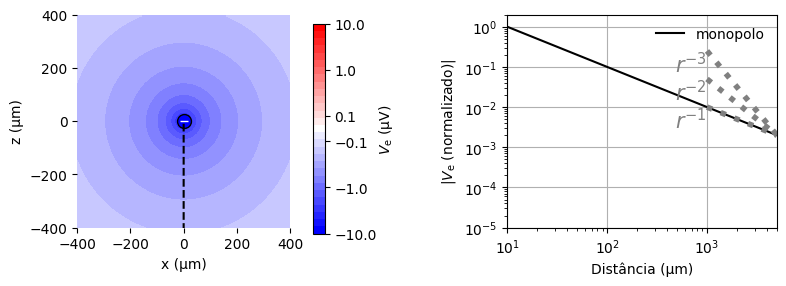

In [5]:
# Amplitude atual do "sink":
imem = np.array([-1.0])

# Posição da fonte:
xs = np.array([0.0])
ys = np.array([0.0])
zs = np.array([0.0])

pos_fontes = np.array([xs, ys, zs])

plotar_potencial_de_fontes_de_corrente(pos_fontes, imem, "monopolo")

### Tarefa 2: Neurônio de dois compartimentos

A seguir, consideramos um modelo de dois compartimentos com uma distância de 100 µm entre o compartimento apical superior e o compartimento do soma inferior. Há um "sink" de corrente de membrana constante de -1.0 nA no compartimento apical. Isso poderia simular o efeito de uma entrada excitatória (realmente) duradoura no compartimento apical.

A fórmula para um neurônio de dois compartimentos é determinada por:

\begin{equation}
V_\mathrm{e}(\mathbf{r})  = \frac{-i}{4 \pi \sigma |\mathbf{r}-\mathbf{r}_d|} + \frac{i}{4 \pi \sigma |\mathbf{r}-\mathbf{r}_s|}
\end{equation}

em que $\mathbf{r}_d$ e $\mathbf{r}_s$ são respectivamente as posições dos compartimentos dendrito e soma e $i=1.0$ nA.

**Para pensar**
1) Qual é a corrente de membrana no compartimento basal?
2) Qual é a corrente axial entre os dois compartimentos?

**Exercício**

4) O que precisamos mudar no código para calcular o potencial extracelular ao redor do neurônio de dois compartimentos?
5) Vamos novamente analisar um gráfico log-log para verificar como o potencial varia com a distância do neurônio ao se mover na direção vertical, ou seja, ao longo da linha que conecta os dois compartimentos, começando a 10 µm abaixo do compartimento do soma. Qual é o decaimento característico? Ele é o mesmo para grandes e pequenas distâncias? Em caso negativo, você tem uma hipótese do por que isso acontece?


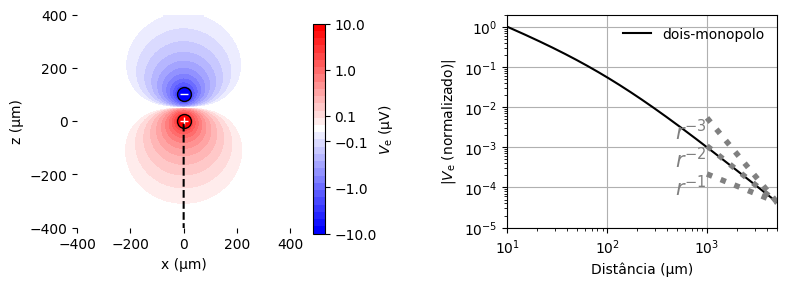

In [6]:
# Amplitude atual das fontes/sinks de corrente:
imem = np.array([1.0, -1.0])

# Posição das fontes:
xs = np.array([0.0, 0.0])
ys = np.array([0.0, 0.0])
zs = np.array([0.0, 100])

pos_fontes = np.array([xs, ys, zs])

plotar_potencial_de_fontes_de_corrente(pos_fontes, imem, "dois-monopolo")

### Tarefa 3: Neurônio de três compartimentos
Agora consideramos um modelo com três compartimentos alinhados verticalmente, onde o compartimento mais baixo corresponde ao soma, enquanto os compartimentos do meio e do topo correspondem aos compartimentos dendríticos. A distância entre os compartimentos vizinhos é de 50 µm. O compartimento do meio é um "sink" de corrente com amplitude constante de -1 nA, enquanto os compartimentos inferior e superior são fontes de corrente, ambos com amplitudes de 0.5 nA. Isso poderia (talvez) simular o efeito de uma entrada excitatória (realmente) duradoura no meio de um compartimento dendrítico apical.

A fórmula para o neurônio de três compartimentos é determinada por:
$$
\begin{equation}
V_\mathrm{e}(\mathbf{r}) = \frac{i_t}{4 \pi \sigma |\mathbf{r}-\mathbf{r}_t|}
+\frac{i_m}{4 \pi \sigma |\mathbf{r}-\mathbf{r}_m|}
+\frac{i_b}{4 \pi \sigma |\mathbf{r}-\mathbf{r}_b|}
\end{equation}
$$

onde $\mathbf{r}_t$, $\mathbf{r}_m$ e $\mathbf{r}_b$ são as posições dos compartimentos superior, médio e inferior, respectivamente. Além disso, $i_t=0.5$ nA, $i_m=-1.0$ nA e $i_b=0.5$ nA.

**Exercício**

1) Repita o que foi feito anteriormente.
2) Como o potencial decai com a distância longe do neurônio? Por quê?

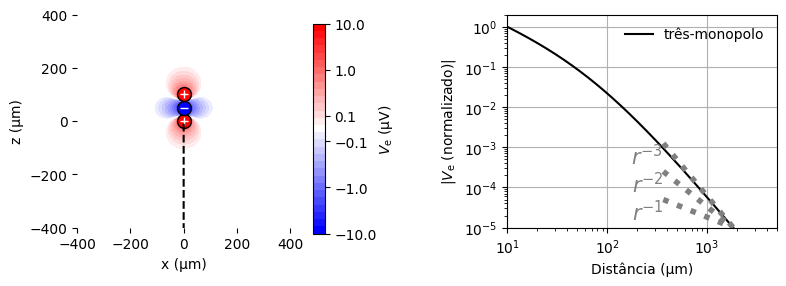

In [7]:
# Amplitude atual das fontes/sinks de corrente:
imem = np.array([0.5, -1, 0.5])

# Posição das fontes:
xs = np.array([0.0, 0.0, 0.0])
ys = np.array([0.0, 0.0, 0.0])
zs = np.array([0.0, 50, 100])

pos_fontes = np.array([xs, ys, zs])

plotar_potencial_de_fontes_de_corrente(pos_fontes, imem, "três-monopolo")

### REFERÊNCIAS


[1] Sterratt, Graham, Gillies, Einevoll, & Willshaw (2023). Principles of Computational Modelling in Neuroscience (2nd ed.) doi:10.1017/9781108672955

## Parte II - Modelo biofisicamente realista

Na aula de "Modelos Biofisicamente Realista" nós discutimos a importância da morfologia para a geração de sinais extracelulares. Além disso, nós exploramos fenômenos de integração sináptica, iniciação de spikes de cálcio e retropropagação utilizando um modelo multicompartimental de um neurônio piramidal do néocortex de rato (Figura 1). Este modelo conta com:

* Morfologia dendrítica anatomicamente reconstruída
* Diversas condutâncias ativas tanto no soma como nos dendritos (incluídas e validadas fitando com dados experimentais)

<img src="Hay-neuron.png" style="height:700px" align="center">

**Figura 1**: Morfologia reconstruída de uma célula piramidal neocortical de rato por Hay et al. (2011). Os locais de registro experimental são indicados por eletrodos esquemáticos no soma (preto), dendrito apical proximal (a 400 µm do soma, azul) e local apical distal (a 620 µm do soma, vermelho). Retirado da Figura 1 em Hay et al. (2011), [http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1002107](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1002107)

### Tarefa 0: Explorando modelos biofisicamente realistas

Antes de estudar como são gerados potenciais extracelulares em neurônios biofisicamente realistas nós vamos explorar como rodar simulações utilizando o NEURON em Python e a biblioteca LFPy. 

**Exercícios**
1) Faça a célula disparar um potencial de ação fornecendo uma ou mais entradas sinápticas. Você pode explorar o que acontece ao variar o número de sinapses, local em que as sinapses ocorrem e as forças sinápticas. Divirta-se!

2) Plote o potencial de membrana "bruto" e normalizado para respostas sublimiares no soma variando de forma crescente a distância das entradas sinápticas e do soma. Descreva o que você observa e como isso se relaciona com os conceitos vistos até agora na disciplina. 

3) Plote o potencial de membrana no soma em resposta a uma entrada de trem de spikes para uma sinapse no dendrito apical distal em um neurônio passivo, ou seja, considerando que estamos bloqueando as condutâncias ativas. Inicialmente, o trem de spikes de entrada deve conter três spikes, com um intervalo entre spikes uniforme de 40 ms. Como as entradas sinápticas se somam no local de entrada? Como elas se somam no compartimento do soma? Como isso muda se a célula tiver todas as condutâncias ativas originais? (Observe que a documentação no código explica como ligar e desligar as condutâncias ativas.)

#### Importando bibliotecas

In [8]:
import os
from os.path import join
import neuron
from neuron import h
import LFPy
from hay_model.hay_active_declarations import active_declarations

h = neuron.h

#### Compilando os arquivos
O código abaixo vai tentar compilar os arquivos NEURON NMODL (.mod). Isto é equivalente a seguinte instrução passada nas aulas anteriores para utilização do NEURON em sua interface gráfica:

Usuários de windows: na pasta onde se encontra instalado o neuron (utilizado na atividade anterior), executar o programa ```mknrndll```. Na tela que aparecerá, selecionar ```Choose directory```, e navegar até o diretório onde foram baixados os arquivos desta atividade. Clicar então em ```Make nrnmech.dll```. 

Usuários de Linux/OSX: executar o comando ```nrnivmodl``` no diretório onde estiverem os arquivos da atividade.

In [9]:
# Esta etapa requer o compilador C correto, que pode depender do seu sistema e do ambiente python (conda) e 
# da maneira como NEURON e LFPy foram instalados.

import os
from os.path import join

# Obter o diretório de trabalho atual
dir_original = os.getcwd()
print("Diretório de trabalho atual %s" % dir_original)

# Navegar para o diretório contendo os arquivos .mod
os.chdir(join("hay_model", "mod"))

# Executar o comando nrnivmodl para converter e compilar os arquivos .mod
!nrnivmodl

# Voltar para o diretório de trabalho original
os.chdir(dir_original)

Diretório de trabalho atual /home/lavinia-lascon/Biofisica/extracelulares
/home/lavinia-lascon/anaconda3/envs/lascon/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/home/lavinia-lascon/Biofisica/extracelulares/hay_model/mod
Mod files: "./CaDynamics_E2.mod" "./Ca_HVA.mod" "./Ca_LVAst.mod" "./Ih.mod" "./Im.mod" "./K_Pst.mod" "./K_Tst.mod" "./Nap_Et2.mod" "./NaTa_t.mod" "./NaTs2_t.mod" "./SK_E2.mod" "./SKv3_1.mod"

Creating 'x86_64' directory for .o files.

 -> Compiling mod_func.cpp
 -> NMODL ../CaDynamics_E2.mod
 -> NMODL ../Ca_HVA.mod
 -> NMODL ../Ca_LVAst.mod
Translating CaDynamics_E2.mod into /home/lavinia-lascon/Biofisica/extracelulares/hay_model/mod/x86_64/CaDynamics_E2.c
Translating Ca_HVA.mod into /home/lavinia-lascon/Biofisica/extracelulares/hay_model/mod/x86_64/Ca_HVA.c
Translating Ca_LVAst.mod into /home/lavinia-lascon/Biofisica/extracelulares/hay_m

In [10]:
# Carregando os mecanismos gerados para o programa
neuron.load_mechanisms(join("hay_model", 'mod'))

True

#### Definindo a função para rodar as simulações

In [11]:
def simular_celula(posicao_sinaptica_y=[900], 
                tipo_condutancia='active', 
                peso=[0.001], 
                spike_train=np.array([10.])):
    """
    Executa uma simulação NEURON e retorna um objeto de célula LFPy para múltiplas entradas sinápticas.
    :param posicao_sinaptica_y: posição ao longo do dendrito apical onde a sinapse é inserida (lista em caso de múltiplas entradas)
    :param tipo_condutancia: 'ativo' ou 'passivo'. 
           Se 'ativo', todos os canais de íons originais são incluídos,
           se 'passivo', eles são todos removidos, resultando em um modelo de célula passiva.
    :param peso: Força da entrada sináptica (lista em caso de múltiplas entradas)
    :param spike_train: Array numpy contendo tempos de spike sinápticos
    :return: objeto de célula onde cell.imem dá correntes transmembranares, 
             cell.vmem dá potenciais de membrana.
             Veja a documentação do LFPy para mais detalhes e exemplos.
    """
    h('forall delete_section()')
    dir_modelo = 'hay_model'
    parametros_celula = {
        'morphology': join(dir_modelo, 'cell1.hoc'),
        'v_init': -65,
        'passive': False,
        'nsegs_method': 'lambda_f',
        'lambda_f': 100,
        'dt': 2**-3,  # Deve ser uma potência de 2
        'tstart': -200,
        'tstop': 200,
        'custom_code': [join(dir_modelo, 'custom_codes.hoc')],
        'custom_fun': [active_declarations],
        'custom_fun_args': [{'conductance_type': tipo_condutancia}],
    }
    celula = LFPy.Cell(**parametros_celula)

    sinapses = np.zeros(len(posicao_sinaptica_y))
    for i, sinapse in enumerate(sinapses):
        parametros_sinapse = {
        # Retorna o compartimento na célula mais próximo das coordenadas:
        'idx': celula.get_closest_idx(x=0., y=posicao_sinaptica_y[i], z=0.),  
        'e': 0.,
        'syntype': 'ExpSyn',
        'tau': 10.,
        'weight': peso[i],
        'record_current': True,
        }
        sinapse = LFPy.Synapse(celula, **parametros_sinapse)
        sinapse.set_spike_times(spike_train)
    
    celula.simulate(rec_imem=True, rec_vmem=True)
        
    celula.strip_hoc_objects()  # corrigir kernels travando com neuron.__version__ >= 7.8
    return celula


#### Definindo a função para auxiliar a plotar os gráficos

In [12]:
def plotar_celula(celula):
    indice_plot_celula = 0
    fig = plt.figure(figsize=(12, 8))
    fig.subplots_adjust(hspace=0.5)  # Ajusta a distância vertical entre os painéis.
    
    ax1 = fig.add_subplot(121, aspect=1, xticks=[], xlabel='x [µm]', ylabel='y [µm]')
    ax1.plot(celula.x.T, celula.y.T, c='k')
    ax1.plot(celula.x.mean(axis=-1)[celula.synidx], celula.y.mean(axis=-1)[celula.synidx], 'ro')
    
    ax2 = fig.add_subplot(222, title='Potencial de membrana', xlabel='Tempo [ms]', ylabel='mV')
    ax2.plot(celula.tvec, celula.vmem[indice_plot_celula, :])
    
    ax3 = fig.add_subplot(224, title='Correntes transmembranares', xlabel='Tempo [ms]', ylabel='nA')
    ax3.plot(celula.tvec, celula.imem[indice_plot_celula, :])
    plt.savefig('exercicio_1_1.png')

#### 1) Faça a célula disparar um potencial de ação fornecendo uma ou mais entradas sinápticas. Você pode explorar o que acontece ao variar o número de sinapses, local em que as sinapses ocorrem e as forças sinápticas. Divirta-se!

active ion-channels inserted.


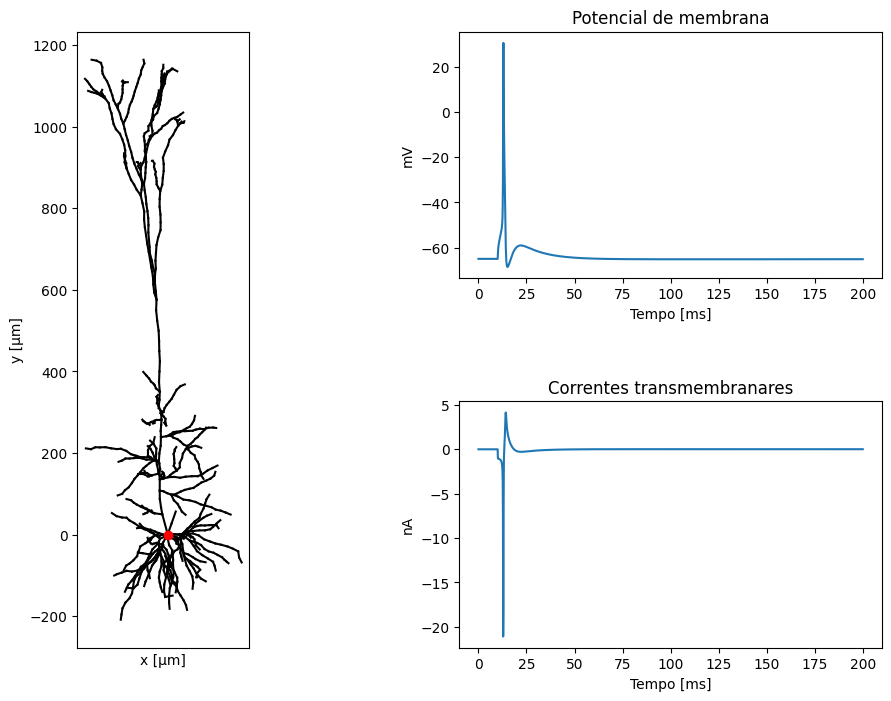

In [13]:
celula = simular_celula(tipo_condutancia='active', peso=[0.02], posicao_sinaptica_y=[0])
plotar_celula(celula)

##### Definindo as funções que calculam o potencial de membrana normalizado e plotam a variação de potencial com a distância

In [14]:
def plota_v_norm(celula, eixos, dist):
    '''Função que plota o potencial de membrana normalizado ao longo do tempo para uma linha de soma específica.
    
    Argumentos:
    - celula: Objeto da célula LFPy contendo os dados do potencial de membrana.
    - eixos: Lista contendo os eixos em que os gráficos serão plotados.
    - dist: Distância ao longo da linha de soma para a qual o potencial de membrana está sendo plotado.
    '''
    indice_plot_celula = 0
    sinal_deslocado = (celula.vmem[indice_plot_celula, :] - celula.vmem[indice_plot_celula, 0])
    eixos[0].plot(celula.tvec, sinal_deslocado/np.max(sinal_deslocado), label='%d µm' % dist)
    eixos[0].set_title("Potencial de membrana normalizado")
    eixos[1].plot(celula.tvec, celula.vmem[indice_plot_celula, :], label='%d µm' % dist)
    eixos[1].set_title("Potencial de membrana 'bruto'")

def plota_variacao_de_v_com_distancia(tipo_condutancia="active"):
    '''Função que plota a variação do potencial de membrana com a distância.
  
  Parâmetros:
    - tipo_condutancia: Tipo de condutância da célula, pode ser "ativo" ou "passivo". Padrão é "ativo".
  
  Gráficos:
    - Esquerda: Potencial de membrana normalizado em função do tempo.
    - Direita: Potencial de membrana bruto em função do tempo.
    '''
    distancias = np.linspace(0, 1200, 5)
    fig = plt.figure(figsize=(12, 8))
    eixo1 = fig.add_subplot(121, ylim=[-0.2, 1.2])
    eixo2 = fig.add_subplot(122, ylim=[-65.2, -64])
    for dist in distancias:
        celula = simular_celula([dist], tipo_condutancia)
        plota_v_norm(celula, [eixo1, eixo2], dist)
    plt.legend()
    plt.savefig('exercicio_1_2_%s.png' % tipo_condutancia)

#### 2) Plote o potencial de membrana "bruto" e normalizado para respostas sublimiares no soma variando de forma crescente a distância das entradas sinápticas e do soma. Descreva o que você observa e como isso se relaciona com os conceitos vistos até agora na disciplina.

Passive dynamics inserted.
Passive dynamics inserted.
Passive dynamics inserted.
Passive dynamics inserted.
Passive dynamics inserted.


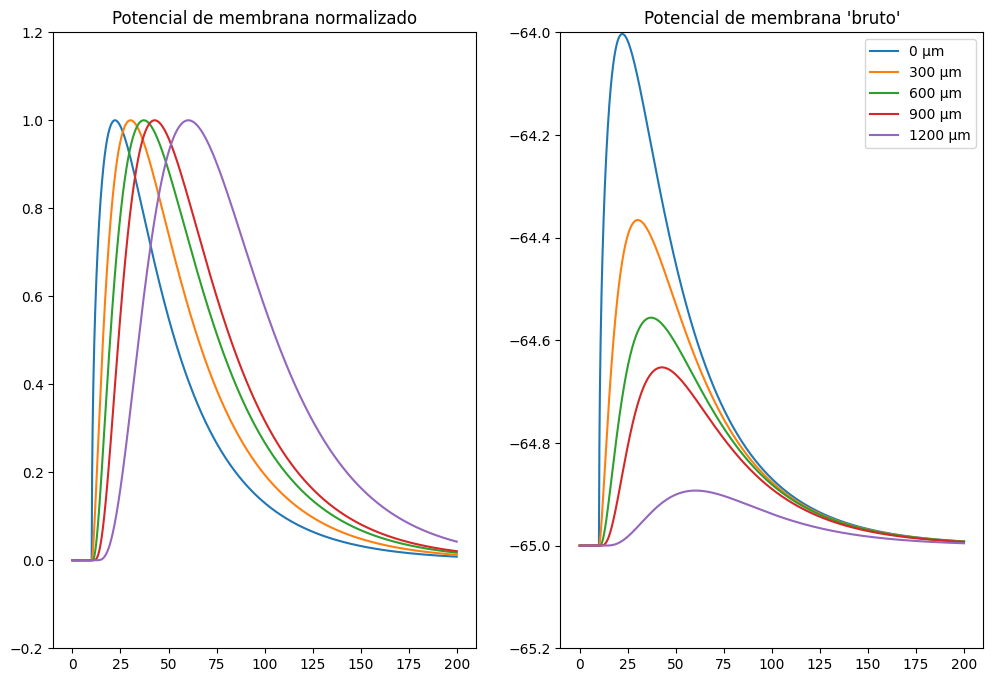

In [15]:
vector = plota_variacao_de_v_com_distancia("passive")

##### Definindo a função que plota a resposta do potencial de membrana a um spike-train

In [16]:
def resposta_spike_train(tipo_condutancia, spike_train=np.array([20, 60, 100])):

    celula = simular_celula(tipo_condutancia=tipo_condutancia, 
                             spike_train=spike_train, 
                             posicao_sinaptica_y=[1100])
    indice_input = celula.synidx[0]
    indice_soma = 0
    fig = plt.figure(figsize=(12, 8))

    fig.text(0.5, 0.95, 'Tipo de condutância: ' + tipo_condutancia.capitalize(), ha='center', size=17)
    fig.subplots_adjust(wspace=0.5, hspace=0.5)
    eixo1 = fig.add_subplot(121, aspect=1)
    eixo1.plot(celula.x.T, celula.y.T, c='k')
    eixo1.plot(celula.x.mean(axis=-1)[celula.synidx], celula.y.mean(axis=-1)[celula.synidx], 'ro')

    eixo2 = fig.add_subplot(222, title='Potencial de membrana\nna entrada', ylim=[-70, -35])
    eixo2.plot(celula.tvec, celula.vmem[indice_input, :])

    eixo3 = fig.add_subplot(224, title='Potencial de membrana\nno soma', ylim=[-65.02, -64.6])
    eixo3.plot(celula.tvec, celula.vmem[indice_soma, :])
    plt.savefig('exercicio_1_3_%s.png' % tipo_condutancia)
    print(indice_input)


#### 3) Plote o potencial de membrana no soma em resposta a uma entrada de trem de spikes para uma sinapse no dendrito apical distal em um neurônio passivo, ou seja, considerando que estamos bloqueando as condutâncias ativas. Inicialmente, o trem de spikes de entrada deve conter três spikes, com um intervalo entre spikes uniforme de 40 ms. Como as entradas sinápticas se somam no local de entrada? Como elas se somam no compartimento do soma? Como isso muda se a célula tiver todas as condutâncias ativas originais? (Observe que a documentação no código explica como ligar e desligar as condutâncias ativas.)

Passive dynamics inserted.
860


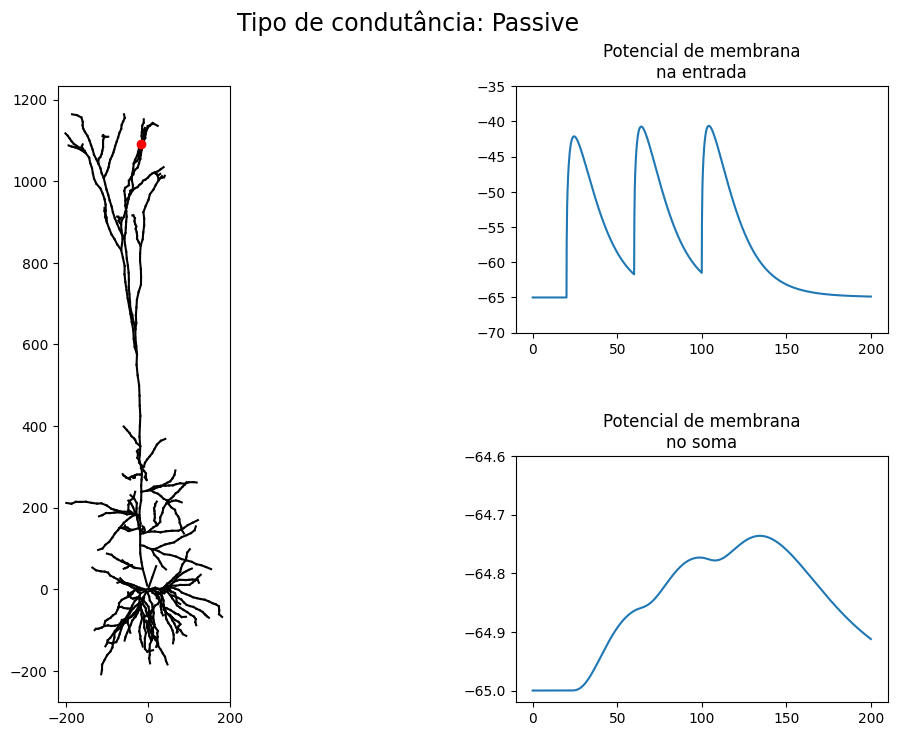

In [17]:
resposta_spike_train("passive")

active ion-channels inserted.
740


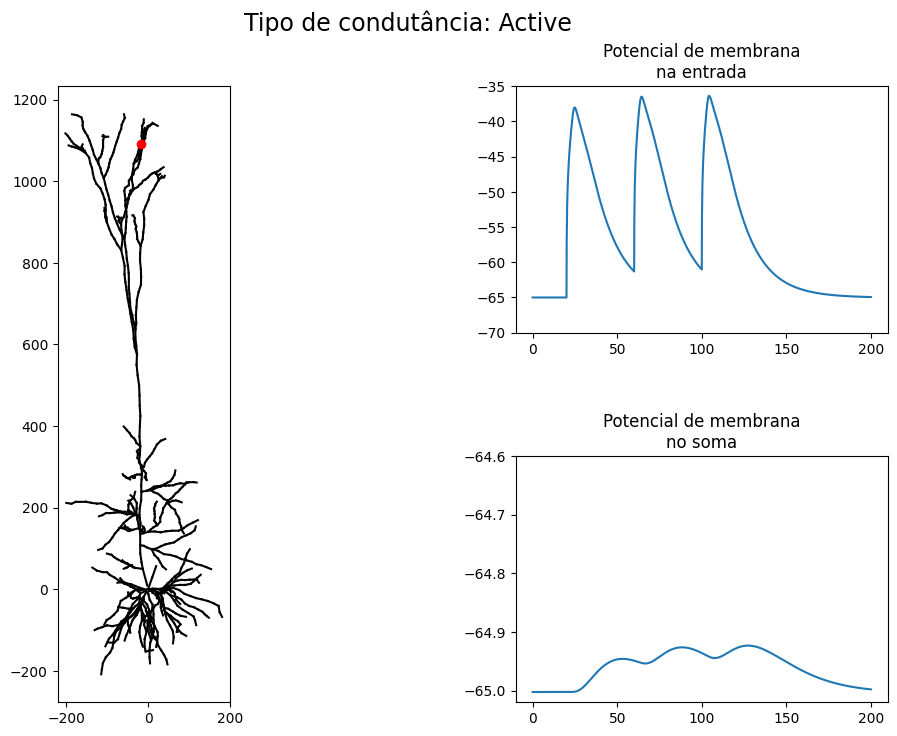

In [18]:
resposta_spike_train("active")

### Tarefa 1: Calculando o LFP gerado por neurônios com morfologia detalhada

Agora que nós já sabemos como simular neurônios biofisicamente detalhados em Python usando o neurosimulador NEURON e a biblioteca LFPy, nós queremos estender os cálculos de potenciais extracelulares que estudamos na Parte I deste tutorial a neurônios com morfologia detalhada.

Nós vamos explorar uma simulação em que uma sinapse no soma elicita um potencial de ação que é registrado por um eletrodo que está posicionado próximo ao soma. Além disso, aplicamos um ruído de fundo de amplitude 15 μV ao sinal extracelular para simular ruído em registros experimentais. 

##### Implementação dos códigos para realizar as atividades


In [19]:
def simular_celula(tipo_condutancia='active'):
    """
    Retorna um objeto LFPy.Cell que contém o modelo Hay.
    
    Parâmetros:
    ===========
    tipo_condutancia: String, opcional. Pode ser 'active' ou 'passive'. 
    Se 'active', inclui as propriedades ativas, i.e., todos os canais iônicos originais são incluídos,
    se 'passive', inclui apenas as propriedades passivas do neurônio. 
    """

    caminho_modelo = join('hay_model')
    #neuron.load_mechanisms(join(caminho_modelo, 'mod'))
    parametros_celula = {
        'morphology': join(caminho_modelo, 'cell1.hoc'),
        'v_init': -65,               # voltagem inicial (mV)
        'passive': False,            # desativa mecanismo de membrana passiva
        'nsegs_method': 'lambda_f',  # método de compartimentalização
        'lambda_f': 100,             # compartimentalização lambda_f_100 (Hines&Carnevale 2001)
        'dt': 2**-4,                 # resolução temporal (ms)
        'tstart': -100,              # tempo de início da simulação (ms)
        'tstop': 100,                # tempo de término da simulação (ms)
        'custom_code': [join(caminho_modelo, 'custom_codes.hoc')],
        'custom_fun': [active_declarations],
        'custom_fun_args': [{'conductance_type': tipo_condutancia}],
    }
    celula = LFPy.Cell(**parametros_celula)
    return celula


def inserir_sinapse(celula, posicao_sinapse_y=0, peso=0.01, trem_spike_entrada=np.array([20.])):
    """
    Insere uma sinapse no modelo de célula fornecido.
    
    Parâmetros:
    ===========
    celula: Objeto LFPy.Cell que contém o modelo de célula.
    posicao_sinetica_y: Float, opcional. Posição ao longo do dendrito apical onde a sinapse é inserida.
    peso: Float, opcional. Força da entrada sináptica
    trem_spike_entrada: Array numpy, opcional. Contém os tempos de pico sináptico.
    """
    parametros_sinapse = {
        'idx': celula.get_closest_idx(x=0., y=posicao_sinapse_y, z=0.),
        'e': 0.,                # potencial de reversão da sinapse (mV)
        'syntype': 'ExpSyn',    # tempo da sinapse
        'tau': 10.,             # constante de tempo da sinapse (ms)
        'weight': peso,       # condutância máxima da sinapse (uS)
        'record_current': True, # grava corrente sináptica
    }
    sinapse = LFPy.Synapse(celula, **parametros_sinapse)
    sinapse.set_spike_times(trem_spike_entrada)
    return sinapse


def criar_eletrodo_extracelular(celula, elec_x=np.array([25.]), elec_y=np.array([0.]), 
                                 elec_z=np.array([0.])):
    """
    Cria um eletrodo extracelular e calcula o potencial extracelular a partir da célula fornecida.
    
    Parâmetros:
    ===========
    celula: Objeto LFPy.Cell que contém o modelo de célula.
    elec_x, elec_y, elec_z: Arrays numpy com as coordenadas x, y, z do(s) eletrodo(s).
    """

    parametros_eletrodo = {
        'sigma': 0.3,  # condutividade extracelular em S/m
        'x': elec_x,  # coordenadas x, y, z dos pontos de contato (um)
        'y': elec_y,
        'z': elec_z,
    }
    eletrodo = LFPy.RecExtElectrode(celula, **parametros_eletrodo)
    M = eletrodo.get_transformation_matrix()
    eletrodo.dados = M @ celula.imem
    return eletrodo


def plotar_sinal_eletrodo(celula, eletrodo, xlim=[15, 55]):
    """
    Plota o potencial da membrana somática e as correntes transmembrana somáticas, bem como a morfologia celular
    e o potencial extracelular.
    
    Parâmetros:
    ===========
    celula: Objeto LFPy.Cell que contém o modelo de célula. Esta função presume que a simulação celular está concluída.
    eletrodo: Objeto do eletrodo da classe LFPy RecExtElectrode.
    """
    indice_plot_celula = 0
    fig = plt.figure(figsize=[12, 9])
    fig.subplots_adjust(hspace=0.5)  # Ajusta a distância vertical entre os painéis.
    ax_celula = fig.add_subplot(132, aspect=1, frameon=False, xticks=[], yticks=[])
    
    cor_eletrodo = lambda idx_eletrodo: plt.cm.jet(idx_eletrodo / len(eletrodo.x))
    
    ax_celula.plot(celula.x.T, celula.y.T, c='k')
    
    for idx in range(len(eletrodo.x)):
        el, = ax_celula.plot(eletrodo.x[idx], eletrodo.y[idx], 'D', c=cor_eletrodo(idx), ms=14)
    sin, = ax_celula.plot(celula.x.mean(axis=-1)[celula.synidx], celula.y.mean(axis=-1)[celula.synidx], '*', c='g', ms=14)
    
    ax_celula.legend([el, sin], ["Eletrodo", "Sinapse"], frameon=False, loc="lower center")
    
    ax_v = fig.add_subplot(231, title='Potencial da membrana somática', xlim=xlim,
                           xlabel='Tempo [ms]', ylabel='mV')
    ax_v.plot(celula.tvec, celula.vmem[indice_plot_celula, :], color='k', lw=2)
    
    ax_i = fig.add_subplot(234, title='Correntes transmembrana somáticas',  xlim=xlim,
                           xlabel='Tempo [ms]', ylabel='nA')
    ax_i.plot(celula.tvec, celula.imem[indice_plot_celula, :], color='k', lw=2)

    np.random.seed(1234)
    # Gera sinal com unidades em uV (em vez de mV) e adiciona ruído branco normalmente distribuído com RMS de 15
    sinal_com_ruido = 1000 * eletrodo.dados + np.random.normal(0, 15, size=eletrodo.dados.shape)
    ylim = np.max(np.abs(sinal_com_ruido)) * 1.2
    ax_ec = fig.add_subplot(133, title='Potencial extracelular', xlim=xlim,
                            xlabel='Tempo [ms]', ylabel='µV', ylim=[-ylim, ylim])
    [ax_ec.plot(celula.tvec, sinal_com_ruido[idx, :], c=cor_eletrodo(idx), lw=2) for idx in range(len(eletrodo.x))]
    
    from plotting_convention import simplify_axes
    simplify_axes([ax_v, ax_i, ax_ec])

def densidade_2D_LFP(celula):
    """
    Função para plotar o potencial extracelular calculado a partir de eletrodos posicionados em uma grade no espaço 2D

    Argumentos:
    - cell: Objeto LFPy.Cell que contém o modelo celular.

    A função plota um mapa de calor do potencial extracelular ao longo de uma grade de posições, 
       representado em um plano (x, z). Semelhante ao gerado na Parte I da atividade. 
    """

    # Criar uma grade densa 2D de eletrodos
    x = np.linspace(-1000, 1000, 26)
    y = np.linspace(-500, 1500, 26)
    x, y = np.meshgrid(x, y)
    elec_x = x.flatten()
    elec_y = y.flatten()
    elec_z = np.zeros(len(elec_x))

    parametros_eletrodo = {
        'sigma': 0.3,  # condutividade extracelular em S/m
        'x': elec_x,  # coordenadas x,y,z dos pontos de contato
        'y': elec_y,
        'z': elec_z,
        }
    eletrodo = LFPy.RecExtElectrode(celula, **parametros_eletrodo)
    M = eletrodo.get_transformation_matrix()
    eletrodo.data = M @ celula.imem

    fig = plt.figure(figsize=[12, 12])
    ax = fig.add_subplot(111, aspect=1, frameon=False, xlabel="x (µm)", ylabel="y (µm)")
    
    ax.plot(celula.x.T, celula.y.T, c='k')
    
    sin, = ax.plot(celula.x.mean(axis=-1)[celula.synidx], celula.y.mean(axis=-1)[celula.synidx], '*', c='g', ms=14)
    
    ax.legend([sin], ["Sinapse"], frameon=False, loc="lower right")
    indice_tempo = np.argmax(celula.vmem[celula.synidx, :])
    amplitude_sig = 1000 * eletrodo.data[:, indice_tempo].reshape(x.shape)
    limite_cor = np.max(np.abs(amplitude_sig))/5
    img = ax.imshow(amplitude_sig, origin='lower', extent=[np.min(x), np.max(x), np.min(y), np.max(y)],
               vmin=-limite_cor, vmax=limite_cor, interpolation='nearest', cmap=plt.cm.bwr)
    plt.colorbar(img, ax=ax, label="µV")


##### Exemplo de utilização dos códigos

active ion-channels inserted.


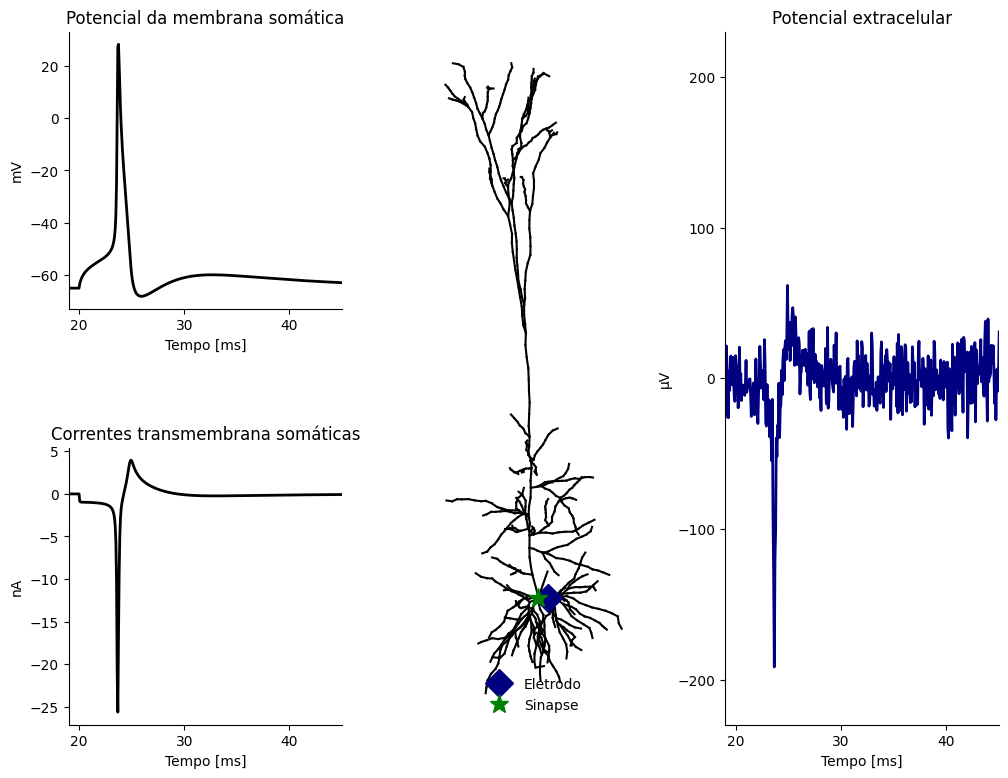

In [21]:
celula = simular_celula(tipo_condutancia="active")
inserir_sinapse(celula, posicao_sinapse_y=0, peso=0.018)
celula.simulate(rec_imem=True, rec_vmem=True)
elec_x = np.array([20.,])
elec_y = np.array([0.0,])
elec_z = np.array([0.0,])
eletrodo = criar_eletrodo_extracelular(celula, elec_x, elec_y, elec_z)
plotar_sinal_eletrodo(celula, eletrodo, xlim=[19, 45])

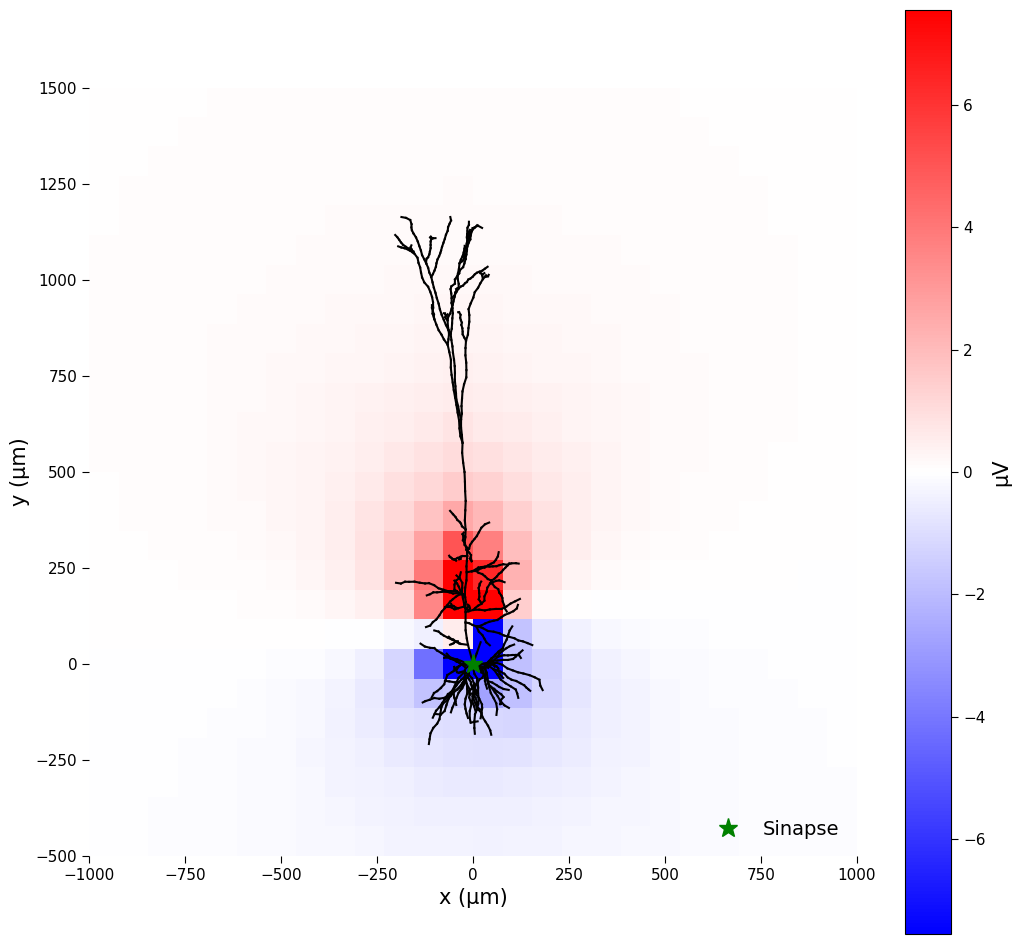

In [22]:
densidade_2D_LFP(celula)

#### 1) Considerando o ruído branco aplicado, estime a distância mínima necessária entre o eletrodo e o soma para que o spike seja visto no sinal extracelular?

**Dica:** O soma da célula é o nosso referencial de distância (origem). Portanto, você pode alterar a distância entre o soma e o eletrodo alterando a coordenadas x, y ou z que definem a localização do eletrodo. Por exemplo, alterando a posição x do eletrodo (elec_x).

active ion-channels inserted.


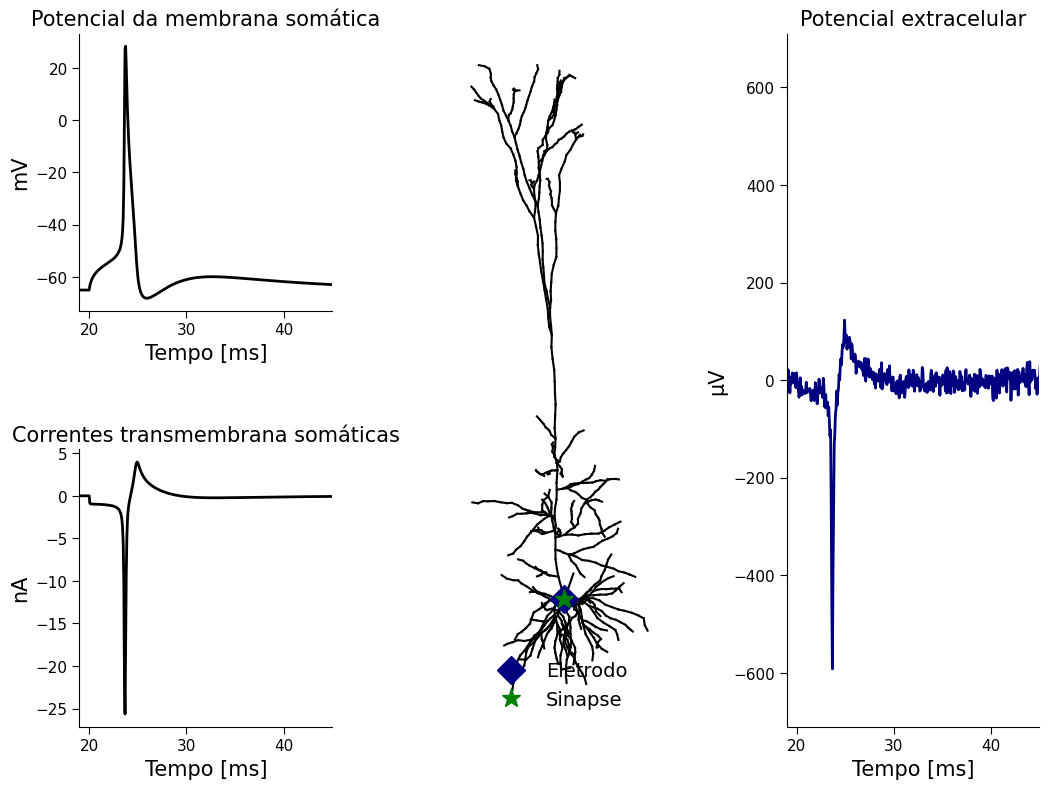

In [23]:
celula = simular_celula(tipo_condutancia="active")
inserir_sinapse(celula, posicao_sinapse_y=0, peso=0.018)
celula.simulate(rec_imem=True, rec_vmem=True)

# Para este exercício você deve alterar a coordenadas abaixo
elec_x = np.array([0.0,])
elec_y = np.array([0.0,])
elec_z = np.array([0.0,])

eletrodo = criar_eletrodo_extracelular(celula, elec_x, elec_y, elec_z)
plotar_sinal_eletrodo(celula, eletrodo, xlim=[19, 45])

### Tarefa 2: Explorando a origem dos sinais de LFP

Em geral, assume-se que os potenciais de campo local (LFPs) são gerados pelas múltiplas entradas sinápticas em grandes populações de células. Para investigar os efeitos dessas sinapses no modelo biofisicamente realista implementado, nós vamos verificar o potencial extracelular registrado em diferentes pontos do espaço (grade 2D), mediante a variações no posicionamento das sinapses. 

**Exercícios**

1) Qual a forma do LFP ao redor das células para uma injeção de corrente sináptica no soma (y=0).
   
2) Qual a forma do LFP ao redor da célular para uma sinapse no centro do denrito apical da célula (y = 600 μm)? E quanto ao dendrito apical distal (y = 1200 μm)?
   
3) Você consegue, com base apenas nos gráficos de densidade do LFP, prever qual dos três decairá mais rapidamente com a distância da célula? Dica: Pode ser interessante pensar sobre as diferenças no decaimento de um dipolo com a distância e no decaimento de multipolos de ordem superior com a distância. 

active ion-channels inserted.


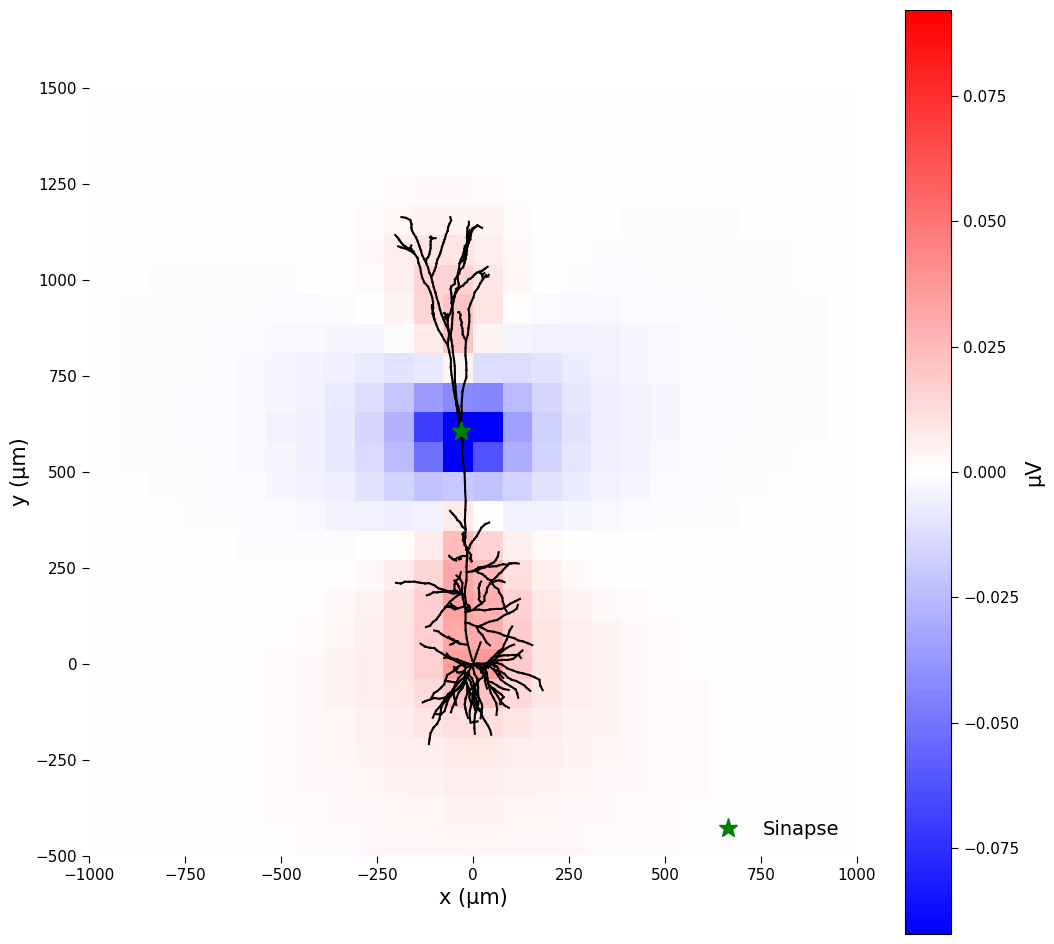

In [24]:
# Para essa atividade você deve alterar o valor de y
y = 600 #μm

celula = simular_celula(tipo_condutancia="active")
inserir_sinapse(celula, posicao_sinapse_y=y, peso=0.001)
celula.simulate(rec_imem=True, rec_vmem=True)
densidade_2D_LFP(celula)

### Tarefa 3: Explorando os efeitos da morfologia na geração de LFPs

Como comentamos anteriormente, na aula de "Modelos Biofisicamente Realistas" nós discutimos que a morfologia é importante para a geração de potenciais extracelulares. 

Nesta parte da atividade nós vamos explorar como diferentes morfologias impactam o sinal extracelular. Para tanto, nós vamos comparar o sinal gerado por um neurônio piramidal da quinta camada (L5) do neocórtex de rato (Hay et al. 2011) e um interneurônio talâmico (Halnes et al. 2011). 

**Exercicíos:**

1) Plote o gráfico 2D de densidade de LFP para o neurônio piramidal e para o interneurônio, ambos recebendo sinapses no soma (y = 0 μm). Explique quais são as principais diferenças observadas em ambos os gráficos e quais diferenças na morfologia do neurônio devem ser importantes para a mudança observada. 

**Dica:** Preste atenção nas escalas e lembre-se que o LFP é gerado de diversas entradas sinápticas para diferentes células. De modo que não é esperado o sinal seja somado da mesma forma nas diferentes morfologias. 

**Para pensar:**

2) Com base em tudo o que fizemos até agora, determine quais os componentes neuronais dominam a geração de sinais de potenciais extracelulares (LFPs). Para saber mais confira o paper: Lindén et al. (2010) Intrinsic dendritic filtering gives low-pass power spectra of local field potentials. J Comput Neurosci 29: 423–444. http://www.ncbi.nlm.nih.gov/pubmed/20502952


In [25]:
def simula_interneuronio():
    """
    Retorna um objeto LFPy.Cell que contém um modelo de interneurônio passivo.
    """

    parametros_celula = {
        'morphology': join('IN.hoc'),
        'v_init': -65,
        'passive': True,
        'nsegs_method': 'lambda_f',
        'lambda_f': 100,
        'dt': 2**-4,  # Deve ser uma potência de 2
        'tstart': -100,
        'tstop': 100,
    }
    celula = LFPy.Cell(**parametros_celula)
    return celula

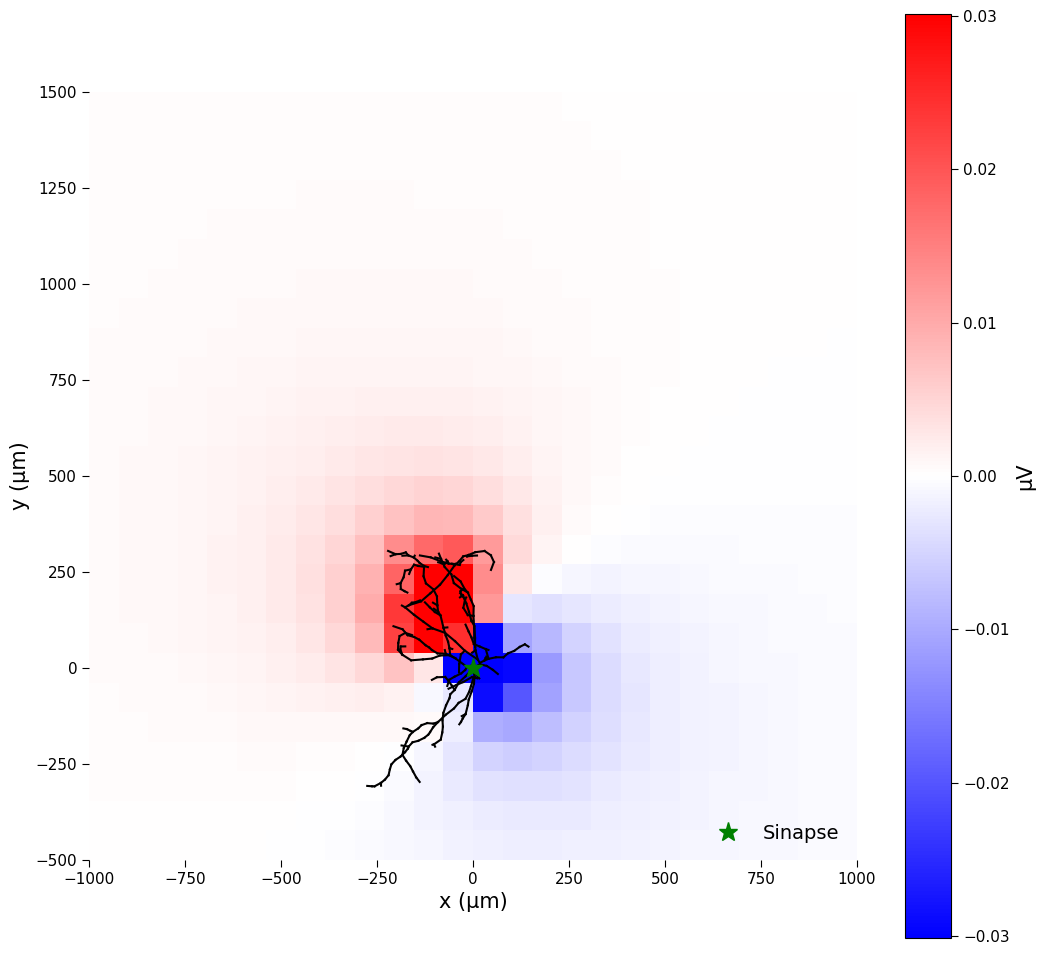

In [26]:
celula = simula_interneuronio()
inserir_sinapse(celula, posicao_sinapse_y=0, peso=0.001)
celula.simulate(rec_imem=True, rec_vmem=True)
densidade_2D_LFP(celula)
plt.savefig("interneuron.png")
